In [1]:
from mdss.ScoringFunctions.Bernoulli import Bernoulli
from mdss.ScoringFunctions.Poisson import Poisson
from mdss.MDSS import MDSS

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']
target_cols = ['diabetes_status_c_qc']

In [3]:
data.site.value_counts()

1    2486
3    2003
Name: site, dtype: int64

In [4]:
numeric_columns = [col for col in data.columns \
                     if (is_numeric_dtype(data[col])) \
                     & (col not in target_cols) \
                     & (data[col].nunique() > 10)]

In [5]:
site_id = 1 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)].copy()
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1465, 25)
Size after removing records with missing targets:  (1465, 25)


In [168]:
dff.loc[((data['htn_jnc7_qc'] == 1) & (data['diabetes_status_c_qc'] == 1)) 
               ].shape[0]/dff.shape[0]*100

5.051194539249146

In [169]:
dff.loc[((data['htn_jnc7_qc'] == 1) & (data['diabetes_status_c_qc'] == 1)) 
               ].shape[0]/dff.loc[((data['diabetes_status_c_qc'] == 1) )].shape[0]*100

77.89473684210526

In [11]:
dff.loc[((data['htn_jnc7_qc'] == 1) )].shape[0]/dff.shape[0]*100

51.94539249146758

In [12]:
dff.loc[((data['diabetes_status_c_qc'] == 1) )].shape[0]/dff.shape[0]*100

6.484641638225256

In [ ]:
dff.loc[((data['htn_jnc7_qc'] == 1) & (data['diabetes_status_c_qc'] == 1)) ]

In [11]:
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

site_id = 3 # 1 - Agincourt, 3 - Nairobi

# Choose the relevant site and age group
dff = data[(data['site'] == site_id) & (data['age'] <= 60) & (data['age'] >= 40)].fillna(-999)

print('Original size: ', dff.shape)
dff = dff[(dff[target_cols] != -999).sum(axis = 1) == len(target_cols)]
print('Size after removing records with missing targets: ', dff.shape)

Original size:  (1465, 25)
Size after removing records with missing targets:  (1465, 25)


In [7]:
dff.columns

Index(['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc',
       'cadiovascular_current', 'bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'friedewald_ldl_c_c_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'site', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc'],
      dtype='object')

In [172]:
dff.loc[:,'ckd_c_qc'].replace([-999], 0)

361     0
366     0
367     0
371     1
375     0
       ..
4475    0
4477    0
4478    0
4484    0
4485    0
Name: ckd_c_qc, Length: 1465, dtype: int64

#### Need to know nature of -999 for CKD conditions

In [8]:
dff.loc[:,'ckd_c_qc'] = dff.loc[:,'ckd_c_qc'].replace([-999], 0)
dff1 = dff.replace([-999, -222, -111, 999], np.nan).copy()

In [9]:
dff1.shape

(1465, 25)

<Axes: ylabel='Density'>

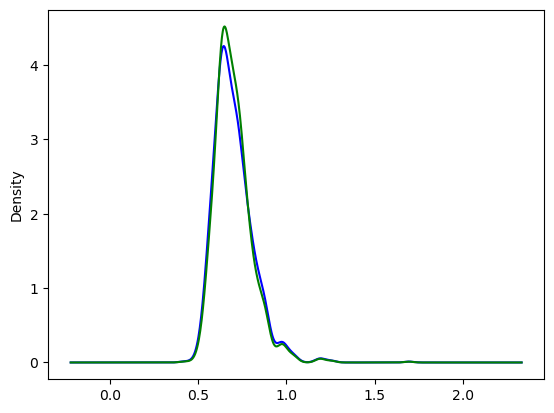

In [10]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff1)
train_t = imputer.transform(dff1)
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=dff1.columns)
# treated = treated.apply(np.ceil)
treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
      = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)

fig = plt.figure()
ax = fig.add_subplot(111)
dff1['cimt_mean_max'].plot(kind='kde', ax=ax, color='blue')
treated['cimt_mean_max'].plot(kind='kde', ax=ax, color='green')

In [ ]:
dff.loc[:,'ckd_c_qc'] = dff.loc[:,'ckd_c_qc'].replace([-999], 0)

In [221]:
target_cols = ['diabetes_status_c_qc']
# target_cols = ['htn_jnc7_qc', 'diabetes_status_c_qc']
target_col = 'diab_hyp'
# target = 'MorbidityCount'

# Specify the columns of interest
columns_of_interest = ['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current'] 

# defining the target column to be a column where the sum of the target values >= 2
# dff[target_col] = (dff[target_cols] == 1).sum(axis = 1) == 2 # *****CHECK********
dff[target_col] = (dff[target_cols] == 1) # *******CHECK**********


# New column
dff['MorbidityCount'] = dff[columns_of_interest].sum(axis=1) # *******CHECK**********

# defining the expectations as mean of the target
dff['expectation'] = dff[target_col].mean()
dff['expectationPoisson'] = dff['MorbidityCount'].median()
# dff['expectation'].head()

# target_col = 'diab_hyp'

# defining the target column to be a column where the sum of the target values >= 2
treated[target_col] = (treated[target_cols] == 1).sum(axis = 1) == 1 # *******CHECK**********
treated['MorbidityCount'] = (treated[columns_of_interest] == 1).sum(axis = 1) # *******CHECK**********

# defining the expectations as mean of the target
treated['expectation'] = treated[target_col].mean()
treated['expectationPoisson'] = treated['MorbidityCount'].mean()

In [190]:
treated.MorbidityCount.value_counts(normalize=True)

1    0.438225
0    0.400683
2    0.141980
3    0.017065
4    0.002048
Name: MorbidityCount, dtype: float64

In [191]:
dff.MorbidityCount.value_counts(normalize=True)

1.0    0.438225
0.0    0.400683
2.0    0.141980
3.0    0.017065
4.0    0.002048
Name: MorbidityCount, dtype: float64

In [17]:
treated.loc[:,['diab_hyp','htn_jnc7_qc', 'diabetes_status_c_qc']]

,diab_hyp,htn_jnc7_qc,diabetes_status_c_qc
0,False,0.0,0.0
1,False,1.0,0.0
2,False,0.0,0.0
3,False,0.0,0.0
4,False,0.0,0.0
...,...,...,...
1460,False,1.0,0.0
1461,True,1.0,1.0
1462,False,0.0,0.0
1463,False,0.0,0.0


In [24]:
# Defining the search space to be all the features except site, study_id, 
# and our created target_col and expectations columns

search_space = [col for col in dff.columns \
                if col not in \
                [target_col, 'site', 'study_id', 'expectation', \
                'htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc', 'cadiovascular_current']]

In [143]:
dff.diab_hyp.value_counts(normalize=True)*100

False    93.515358
True      6.484642
Name: diab_hyp, dtype: float64

In [32]:
search_space

['bmi_c_qc',
 'age',
 'cimt_mean_max',
 'cholesterol_1_qc',
 'friedewald_ldl_c_c_qc',
 'hdl_qc',
 'triglycerides_qc',
 'waist_hip_r_c_qc',
 'waist_circumference_qc',
 'visceral_fat_qc',
 'subcutaneous_fat_qc',
 'sex',
 'hiv_final_status_c',
 'highest_level_of_education_qc',
 'partnership_status_c_qc',
 'ses_site_quintile_c_qc',
 'occupation_qc',
 'mvpa_cat_c',
 'alcohol_use_status_c_qc',
 'smoking_status_c_qc']

In [33]:
len(search_space)

20

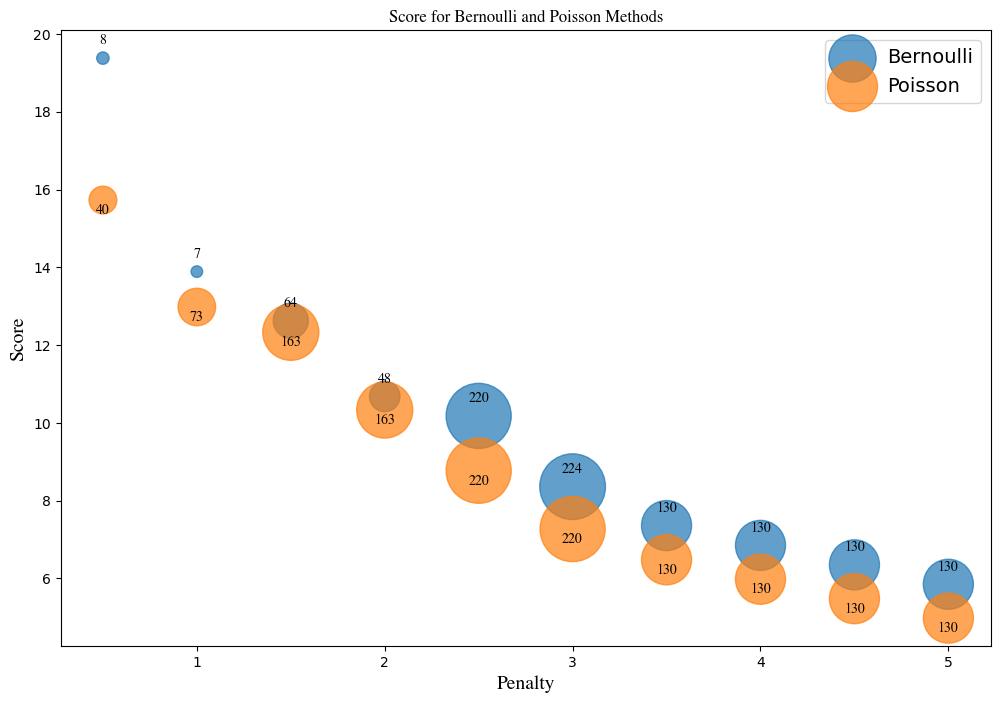

In [302]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data
data = {
    'Penalty': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
    'score_Bernoulli': [19.38, 13.89, 12.63, 10.68, 10.18, 8.36, 7.36, 6.85, 6.35, 5.85],
    'Size_Bernoulli': [8, 7, 64, 48, 220, 224, 130, 130, 130, 130],
    'score_Poisson': [15.73, 12.98, 12.33, 10.33, 8.77, 7.27, 6.48, 5.98, 5.48, 4.98],
    'Size_Poisson': [40, 73, 163, 163, 220, 220, 130, 130, 130, 130],
    'Literals_Bernoulli': [9, 7, 5, 3, 3, 3, 1, 1, 1, 1],
    'Literals_Poisson': [11, 8, 4, 4, 3, 3, 1, 1, 1, 1]
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 8))

# Plot Odds for Bernoulli
plt.scatter(df['Penalty'], df['score_Bernoulli'], s=df['Size_Bernoulli']*10, label='Bernoulli', alpha=0.7)

# Plot Odds for Poisson
plt.scatter(df['Penalty'], df['score_Poisson'], s=df['Size_Poisson']*10, label='Poisson', alpha=0.7)

# Annotate the size values for Bernoulli
for i, txt in enumerate(df['Size_Bernoulli']):
    plt.annotate(txt, (df['Penalty'][i], df['score_Bernoulli'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontname="Times")

# Annotate the size values for Poisson
for i, txt in enumerate(df['Size_Poisson']):
    plt.annotate(txt, (df['Penalty'][i], df['score_Poisson'][i]), textcoords="offset points", xytext=(0,-10), ha='center', fontname="Times")

hfont = {'fontname':'Comic Sans MS'}
# Add labels and title
plt.xlabel('Penalty', fontsize=14, fontname="Times")
plt.ylabel('Score', fontsize=14, fontname="Times")
plt.title('Score for Bernoulli and Poisson Methods', fontname="Times")
plt.legend(fontsize="14")

# Show the plot
plt.show()


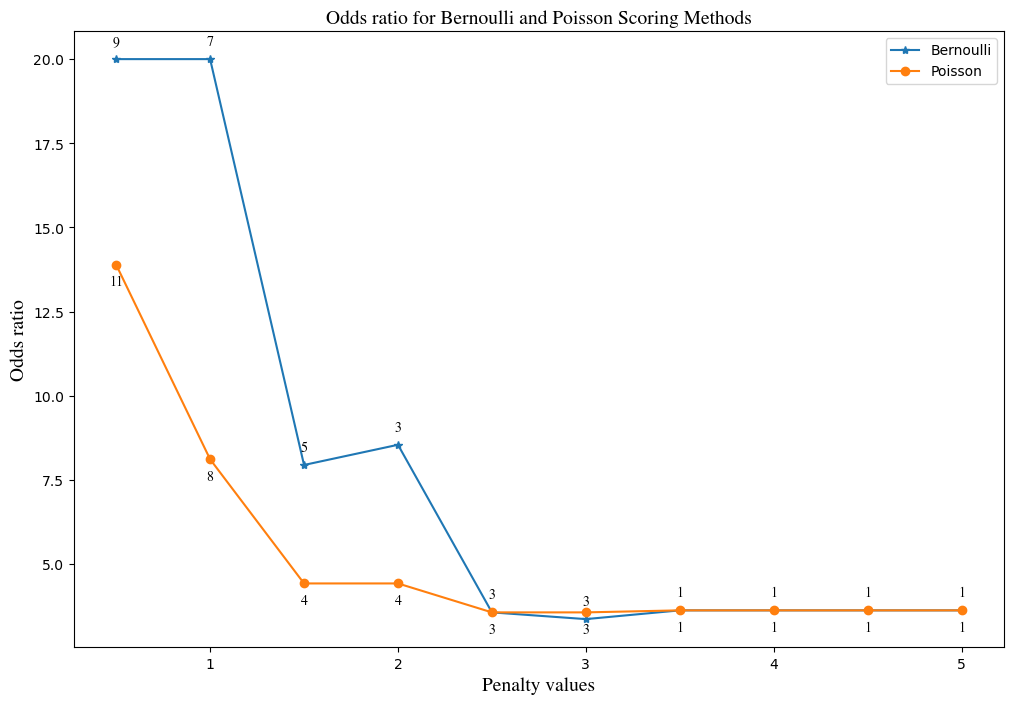

In [305]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data
data = {
    'Penalty': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
    'Odds_Bernoulli': [20, 20, 7.94, 8.54, 3.56, 3.36, 3.62, 3.62, 3.62, 3.62],
    'Size_Bernoulli': [8, 7, 64, 48, 220, 224, 130, 130, 130, 130],
    'Odds_Poisson': [13.89, 8.11, 4.42, 4.42, 3.56, 3.56, 3.62, 3.62, 3.62, 3.62],
    'Size_Poisson': [40, 73, 163, 163, 220, 220, 130, 130, 130, 130],
    'Literals_Bernoulli': [9, 7, 5, 3, 3, 3, 1, 1, 1, 1],
    'Literals_Poisson': [11, 8, 4, 4, 3, 3, 1, 1, 1, 1]
}

df = pd.DataFrame(data)

# Plotting as a line chart
plt.figure(figsize=(12, 8))

# Plot Odds for Bernoulli
plt.plot(df['Penalty'], df['Odds_Bernoulli'], marker='*', label='Bernoulli')

# Plot Odds for Poisson
plt.plot(df['Penalty'], df['Odds_Poisson'], marker='o', label='Poisson')
    
# Annotate the size values for Bernoulli
for i, txt in enumerate(df['Literals_Bernoulli']):
    plt.annotate(txt, (df['Penalty'][i], df['Odds_Bernoulli'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontname="Times")

# Annotate the size values for Poisson
for i, txt in enumerate(df['Literals_Poisson']):
    plt.annotate(txt, (df['Penalty'][i], df['Odds_Poisson'][i]), textcoords="offset points", xytext=(0,-15), ha='center', fontname="Times")

# Add labels and title
plt.xlabel('Penalty values', fontname="Times", fontsize=14)
plt.ylabel('Odds ratio', fontname="Times", fontsize=14)
plt.title('Odds ratio for Bernoulli and Poisson Scoring Methods', fontname="Times", fontsize=14)
plt.legend()

# Show the plot
# plt.grid(True)
plt.show()


In [222]:
def get_str(x):
    # This function turns a pandas bin to a meaningful string
    s = str(round(x.left, 2)) + ' - ' + str(round(x.right,2))
    return s

def custom_qcut(ser, contiguous = True):
    # Get the rows that are actual numbers
    sub_ser = ser[(ser != -111) \
                     & (ser != -222) \
                     & (ser != -555) \
                     & (ser != -999)]
    
    if contiguous:
        # if contiguous, treat all the special numbers the same
        ser = ser.replace(-111 , -999)
        ser = ser.replace(-222 , -999)
        ser = ser.replace(-555 , -999)

    # Bin the actual numbers into 10 bins for scanning
    sub_ser = pd.qcut(sub_ser, 10, duplicates='drop')
    sub_ser = sub_ser.apply(get_str).astype(str)
    ser[list(sub_ser.index)] = sub_ser
    return ser


In [223]:
contiguous = {}
dff_2 = dff.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

#### For treated missingness
Rerun the next cells and jump to next markdown cell

In [34]:
contiguous = {}
dff_2 = treated.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

In [199]:
def compress_contiguous(subset, contiguous):
    # Shorten a contiguous list e.g [0-9, 10-19] is converted to [0 - 19] 
    new = {}
    
    for col in subset:
        if col in contiguous:
            if isinstance(subset[col][0], (float,int)):
                new[col] = [str(c) for c in subset[col]]
                continue
            i = -1 if isinstance(subset[col][-1], str) else -2
            new[col] = [subset[col][0].split(' - ')[0] + ' - ' + subset[col][i].split(' - ')[-1]]
            new[col] = new[col] if i == -1 else new[col] + [str(subset[col][-1])]
        else:
            new[col] = [str(c) for c in subset[col]]
    return new

def translate_subset_to_rule(subset):
    # Print the subset as a rule for easier understanding
    desc = ''
    for key, value in subset.items():
        # desc += key + ' = {' + ' OR '.join(value) + '} AND' + '\n'
        desc += key + '{' + ' OR '.join(value) + '} AND' + ' '

    return desc[:-5].replace('_',' ').replace('{', '[').replace('}', ']')

def count_conditions(subset):
    # Split the string by 'AND' and 'OR'
    conditions = subset.replace("AND", "OR").split("OR")
    
    # Count the number of conditions
    condition_count = len(conditions)
    
    return condition_count

In [133]:
temp_df.diab_hyp.value_counts(normalize=True)*100

False    79.230769
True     20.769231
Name: diab_hyp, dtype: float64

In [124]:
temp_df.diabetes_status_c_qc.value_counts(normalize=True)*100

0    79.230769
1    20.769231
Name: diabetes_status_c_qc, dtype: float64

In [197]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
# penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
penalty_values = [1.0, 1.5, 2, 2.5]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
odds_results = []
count_results = []
dataframes = {}

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]

    # Store each DataFrame in the dictionary with a unique key
    dataframes[f'df_{penalty}'] = temp_df

    size = len(temp_df)
    observed_income = np.round(temp_df[target_col].mean(), 3)
    positive_class_count = temp_df[target_col].sum()

    group_obs = temp_df[target_col].mean()
    group_prob = temp_df['expectation'].mean()
    odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))
    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(np.round(score, 3))
    size_results.append(size)
    odds_results.append(np.round(odds_mul, 3))
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)


# # Display the results for each penalty value
# for i, penalty in enumerate(penalty_values):
#     print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, Odds = {odds_results[i]}, Score = {score_results[i]}")

Penalty = 1.0: Subset = age[47.0 - 60.0] AND,bmi c qc[21.31 - 35.9] AND,waist hip r c qc[0.94 - 1.16 OR -999.0] AND,hiv final status c[0], 
LiteralsNumber = 5, 
Size = 164, Odds = 4.499, Score = 17.313
Penalty = 1.5: Subset = age[47.0 - 60.0] AND,bmi c qc[21.31 - 35.9] AND,waist hip r c qc[0.94 - 1.16] AND,hiv final status c[0], 
LiteralsNumber = 4, 
Size = 163, Odds = 4.384, Score = 15.194
Penalty = 2: Subset = waist hip r c qc[0.94 - 1.16] AND,bmi c qc[21.31 - 35.9] AND,age[47.0 - 60.0] AND,hiv final status c[0], 
LiteralsNumber = 4, 
Size = 163, Odds = 4.384, Score = 13.194
Penalty = 2.5: Subset = cimt mean max[0.78 - 1.7 OR -999.0] AND,waist hip r c qc[1.0 - 1.16], 
LiteralsNumber = 3, 
Size = 48, Odds = 9.448, Score = 10.983


In [198]:
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Odds': odds_results,
    'Score': score_results
})

# Display the DataFrame
results_df


,Penalty,No of literals,Subset,Size,Odds,Score
0,1.0,5,"age[47.0 - 60.0] AND,bmi c qc[21.31 - 35.9] AN...",164,4.499,17.313
1,1.5,4,"age[47.0 - 60.0] AND,bmi c qc[21.31 - 35.9] AN...",163,4.384,15.194
2,2.0,4,"waist hip r c qc[0.94 - 1.16] AND,bmi c qc[21....",163,4.384,13.194
3,2.5,3,"cimt mean max[0.78 - 1.7 OR -999.0] AND,waist ...",48,9.448,10.983


In [148]:
import pandas as pd

# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Odds': odds_results,
    'Score': score_results
})

# Display the DataFrame
results_df


,Penalty,No of literals,Subset,Size,Odds,Score
0,1.0,8,"triglycerides qc = (0.46 - 5.34) AND,visceral ...",44,13.167,20.539
1,1.5,4,"waist hip r c qc = (0.94 - 1.16) AND,bmi c qc ...",163,4.384,17.825
2,2.0,3,"cimt mean max = (0.78 - 1.7 OR -999.0) AND,wai...",48,9.448,15.702
3,2.5,4,"bmi c qc = (21.31 - 35.9) AND,age = (47.0 - 60...",163,4.384,13.825


In [ ]:
dataframes['df_0.5']

In [54]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Poisson(direction='positive')
scanner = MDSS(scoring_function)

penalty = 1.0
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 246 ms, sys: 84.6 ms, total: 331 ms
Wall time: 5.51 s


({'triglycerides_qc': ['0.46 - 0.54',
   '0.54 - 0.62',
   '0.62 - 0.7',
   '0.7 - 0.78',
   '0.78 - 0.88',
   '0.88 - 1.0',
   '1.0 - 1.14',
   '1.14 - 1.49',
   '1.49 - 5.34'],
  'visceral_fat_qc': ['1.2 - 3.15',
   '3.15 - 4.27',
   '4.27 - 4.98',
   '4.98 - 5.56',
   '5.56 - 6.11',
   '6.11 - 6.58',
   -999.0],
  'subcutaneous_fat_qc': ['2.06 - 2.46',
   '2.46 - 2.93',
   '2.93 - 4.57',
   '4.57 - 10.41',
   -999.0],
  'waist_hip_r_c_qc': ['0.97 - 1.0', '1.0 - 1.16'],
  'hiv_final_status_c': [0],
  'hdl_qc': ['0.29 - 0.81',
   '0.81 - 0.92',
   '0.92 - 0.99',
   '0.99 - 1.06',
   '1.06 - 1.14',
   '1.14 - 1.22',
   '1.22 - 1.31',
   '1.31 - 1.45']},
 20.539424053488933)

In [57]:
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

triglycerides qc = (0.46 - 5.34) AND
visceral fat qc = (1.2 - 6.58 OR -999.0) AND
subcutaneous fat qc = (2.06 - 10.41 OR -999.0) AND
waist hip r c qc = (0.97 - 1.16) AND
hiv final status c = (0) AND
hdl qc = (0.29 - 1.45)


In [177]:
# print some information about the subset
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average \
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 130 
Recall that our population average is 0.05051194539249147      
In this subgroup, we observe a mean outcome of 0.162
With 21 individuals in the group above average       
This is a multiplicative factor in the odds (i.e q) of 3.621


In [178]:
pen7 = temp_df

In [185]:
dff_2.shape

(1465, 27)

In [322]:
del final_df

In [111]:
# Identify unique observations from the datasets
unique_ids = np.unique(np.concatenate([dataframes['df_1.5'].index, dataframes['df_3.5'].index, dataframes['df_4.5'].index,]))

# Create a DataFrame with values of 1 in the baseline column and 0 or 1 in the other columns
final_df = pd.DataFrame(index=unique_ids, columns=['4_literals', '3_literals', '1_literal'])

# Set values based on the presence of IDs in the datasets
# final_df['Baseline'] = 1
final_df['4_literals'] = final_df.index.isin(dataframes['df_1.5'].index).astype(int)
final_df['3_literals'] = final_df.index.isin(dataframes['df_3.5'].index).astype(int)
final_df['1_literal'] = final_df.index.isin(dataframes['df_4.5'].index).astype(int)

# Display the final DataFrame
print(final_df)

      4_literals  3_literals  1_literal
378            1           1          1
379            0           0          1
388            1           0          1
389            0           0          1
397            1           0          0
...          ...         ...        ...
4394           0           0          1
4422           1           0          0
4471           0           0          1
4472           1           0          0
4477           1           0          0

[242 rows x 3 columns]


In [112]:
# get coordinates where event occurs (value=1)
row_paths, col_paths = np.where(final_df.eq(1))
mask = pd.DataFrame(data= {'rows':row_paths, 'cols':col_paths})

# aggregate by row to get application's path
agg_mask = mask.groupby('rows').apply(lambda x: [x for x in x.cols])
agg_mask.tail()

rows
237    [2]
238    [0]
239    [2]
240    [0]
241    [0]
dtype: object

In [113]:
all_events = []

# get pair of source and target
for row in agg_mask:
    for index in range(len(row)-1):
        all_events.append([row[index], row[index+1]])
        
# create df for aggregation        
sankey_ST = pd.DataFrame(data=all_events)
sankey_ST = sankey_ST.rename(columns={0:'source', 1:'target'})
sankey_ST = sankey_ST.value_counts().reset_index()
sankey_ST = sankey_ST.rename(columns={0:'value'})

sankey_ST.head()

,source,target,value
0,1,2,48
1,0,2,27
2,0,1,24


In [114]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        label = [f'{x}: {final_df[x].sum()}' for x in final_df.columns]
    ),
    link=dict(
        source = sankey_ST['source'],
        target = sankey_ST['target'],
        value = sankey_ST['value']
    ),
)])


fig.update_layout(title_text='Sankey plot for flow of literals', font_size=10)
fig.update_traces(textfont_size=12)
fig.show()

#### Use Poisson distribution for the scoring (utility) function

In [147]:
%%time
from mdss.ScoringFunctions.Poisson import Poisson
# Scan in the positive direction using defined penalties and num iters

scoring_function = Poisson(direction='positive')
scanner = MDSS(scoring_function)

penalty = 5
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 228 ms, sys: 78.4 ms, total: 306 ms
Wall time: 2.86 s


({'waist_hip_r_c_qc': ['1.0 - 1.16']}, 4.979754626835501)

In [148]:
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

waist hip r c qc = (1.0 - 1.16)


In [150]:
# print some information about the subset
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average \
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 130 
Recall that our population average is 0.05051194539249147      
In this subgroup, we observe a mean outcome of 0.162
With 21 individuals in the group above average       
This is a multiplicative factor in the odds (i.e q) of 3.621


In [152]:
# function to get records of returned subset definition
def get_subset_dataframe(subset, data):
    """ 
    This function takes a subset definition and returns a dataframe of records specified in the subset.
    Parameters:
    subset (dict): A dictionary where each key-value pair represents a column name and its corresponding
    value to filter the dataframe.
    data (pd.DataFrame): The original pandas dataframe from which the subset is to be extracted.
    Returns:
    pd.DataFrame: A new dataframe containing only the records that match the specified subset criteria.
    """
    # select indices of column/value pairs in the subset description from the original dataset
    to_choose = data[subset[0].keys()].isin(subset[0]).all(axis=1)
    # slice indices from original dataset and reset the index
    subset_df = data.loc[to_choose].reset_index(drop=True)

    return subset_df
subset_df = get_subset_dataframe(subset,dff)
subset_df.head()

KeyError: 0

In [154]:
# print some information about the subset
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average \
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 50 
Recall that our population average is 0.05051194539249147      
In this subgroup, we observe a mean outcome of 0.32
With 16 individuals in the group above average       
This is a multiplicative factor in the odds (i.e q) of 8.846


In [28]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]

# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0', '780.0 - 810.0', '810.0 - 860.0', '860.0 - 900.0', '900.0 - 950.0', '950.0 - 990.0'], 'highest_level_of_education_qc': [0.0, 2.0], 'occupation_qc': [2.0, 3.0, 4.0], 'visceral_fat_qc': ['2.82 - 4.16', '4.16 - 4.87', '4.87 - 5.42', '5.42 - 5.91', '5.91 - 6.36', '6.36 - 6.85', '6.85 - 7.63'], 'triglycerides_qc': ['0.46 - 0.55', '0.55 - 0.63', '0.63 - 0.71', '0.71 - 0.8', '0.8 - 0.89', '0.89 - 0.98', '0.98 - 1.12', '1.12 - 1.47', '1.47 - 5.34']}, Score = 9.4674689699748
Penalty = 2: Subset = {'age': ['40.0 - 42.0', '42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0'], 'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 10.56486285033507
Penalty = 3: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 9.509913245048368
Penalty = 4: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score 

In [29]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)

penalty = 3
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 317 ms, sys: 90.3 ms, total: 407 ms
Wall time: 5.19 s


({'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']},
 9.509913245048368)

In [30]:
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

waist circumference qc = (510.0 - 780.0)


In [31]:
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average\
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 315 
Recall that our population average is 0.05051194539249148      
In this subgroup, we observe a mean outcome of 0.003
With 1 individuals in the group above average      
This is a multiplicative factor in the odds (i.e q) of 0.06


### AS for treated missingness

In [32]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'cholesterol_1_qc': ['0.3 - 2.78', '2.78 - 3.16', '3.16 - 3.47', '3.47 - 3.71', '3.71 - 3.99', '3.99 - 4.15', '4.15 - 4.46', '4.46 - 4.78'], 'bmi_c_qc': ['27.97 - 30.09', '30.09 - 32.59', '32.59 - 35.92', '35.92 - 68.02'], 'subcutaneous_fat_qc': ['1.54 - 1.82', '1.82 - 2.17', '2.17 - 2.54', '2.54 - 2.95', '2.95 - 4.28', '4.28 - 10.41'], 'ses_site_quintile_c_qc': [5.0], 'visceral_fat_qc': ['-0.74 - 2.82', '2.82 - 4.16', '4.16 - 4.87', '4.87 - 5.42', '5.42 - 5.91', '5.91 - 6.36', '6.36 - 6.85', '6.85 - 7.63', '7.63 - 8.64'], 'cimt_mean_max': ['0.62 - 0.64', '0.64 - 0.66', '0.66 - 0.68', '0.68 - 0.71', '0.71 - 0.74', '0.74 - 0.77', '0.77 - 0.83', '0.83 - 1.7'], 'waist_hip_r_c_qc': ['0.94 - 0.97', '0.97 - 1.0', '1.0 - 1.16'], 'age': ['42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0', '57.0 - 58.0']}, Score = 11.813000759857985
Penalty = 2: Subset = {'friedewald_ldl_c_c_qc': ['-3.31 - 1.37', '1.37 - 1.69', '1.69 - 

In [33]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='positive')
scanner = MDSS(scoring_function)

penalty = 7
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 275 ms, sys: 77.1 ms, total: 352 ms
Wall time: 4.26 s


({'cimt_mean_max': ['0.74 - 0.77', '0.77 - 0.83', '0.83 - 1.7'],
  'waist_hip_r_c_qc': ['1.0 - 1.16']},
 4.187553177273294)

In [34]:
# print the subset we obtained as a rule
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

cimt mean max = (0.74 - 1.7) AND
waist hip r c qc = (1.0 - 1.16)


In [35]:
# print some information about the subset
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average \
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 50 
Recall that our population average is 0.05051194539249147      
In this subgroup, we observe a mean outcome of 0.32
With 16 individuals in the group above average       
This is a multiplicative factor in the odds (i.e q) of 8.846


In [36]:
# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [1, 2, 3, 4, 5, 6, 7]

# Initialize empty lists to store results
subset_results = []
score_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    # Append the results to the respective lists
    subset_results.append(subset)
    score_results.append(score)

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

Penalty = 1: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0', '780.0 - 810.0', '810.0 - 860.0', '860.0 - 900.0', '900.0 - 950.0', '950.0 - 990.0'], 'highest_level_of_education_qc': [0.0, 2.0], 'occupation_qc': [2.0, 3.0, 4.0], 'visceral_fat_qc': ['2.82 - 4.16', '4.16 - 4.87', '4.87 - 5.42', '5.42 - 5.91', '5.91 - 6.36', '6.36 - 6.85', '6.85 - 7.63'], 'triglycerides_qc': ['0.46 - 0.55', '0.55 - 0.63', '0.63 - 0.71', '0.71 - 0.8', '0.8 - 0.89', '0.89 - 0.98', '0.98 - 1.12', '1.12 - 1.47', '1.47 - 5.34']}, Score = 9.4674689699748
Penalty = 2: Subset = {'age': ['40.0 - 42.0', '42.0 - 44.0', '44.0 - 47.0', '47.0 - 50.0', '50.0 - 51.0', '51.0 - 53.0', '53.0 - 55.0', '55.0 - 57.0'], 'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 10.56486285033507
Penalty = 3: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score = 9.509913245048368
Penalty = 4: Subset = {'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']}, Score 

In [37]:
%%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Bernoulli(direction='negative')
scanner = MDSS(scoring_function)

penalty = 6
num_iters = 10

subset, score = scanner.scan(dff_2[search_space], dff_2[target_col], dff_2['expectation'],cpu = .95,
                             penalty = penalty, num_iters = num_iters, contiguous = contiguous.copy())
subset, score

CPU times: user 298 ms, sys: 80.6 ms, total: 378 ms
Wall time: 3.36 s


({'waist_circumference_qc': ['510.0 - 740.0', '740.0 - 780.0']},
 6.509913245048368)

In [38]:
# print the subset we obtained as a rule
print(translate_subset_to_rule(compress_contiguous(subset, contiguous)))

waist circumference qc = (510.0 - 780.0)


In [39]:
# print some information about the subset
to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
temp_df = dff_2.loc[to_choose]

size = len(temp_df)
observed_income = np.round(temp_df[target_col].mean(), 3)
positive_class_count = temp_df[target_col].sum()

group_obs = temp_df[target_col].mean()
group_prob = temp_df['expectation'].mean()
odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))

print("Our detected subgroup has a size of {} \nRecall that our population average is {}\
      \nIn this subgroup, we observe a mean outcome of {}\nWith {} individuals in the group above average \
      \nThis is a multiplicative factor in the odds (i.e q) of {}".\
      format(size, group_prob , observed_income, positive_class_count, np.round(odds_mul, 3)))

Our detected subgroup has a size of 315 
Recall that our population average is 0.05051194539249148      
In this subgroup, we observe a mean outcome of 0.003
With 1 individuals in the group above average       
This is a multiplicative factor in the odds (i.e q) of 0.06


In [87]:
contiguous = {}
dff_2 = treated.copy()

# Create a new dataframe with the numeric columns bins     
for col in numeric_columns:
    if col in search_space:
        dff_2[col] = custom_qcut(dff_2[col].copy())
        
        bins = list(dff_2[col].unique())
        
        if -999 in bins:
            bins.remove(-999)
        
        bins = sorted(bins, key=lambda x : float(x.split(' - ')[0]))
        
        contiguous[col] = bins

### Poisson-based scanning for Count variables

In [89]:
%%time
from mdss.ScoringFunctions.Poisson import Poisson
# Scan in the positive direction using defined penalties and num iters

# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Poisson(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
# penalty_values = [1.3, 1.5, 2, 2.5]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
odds_results = []
count_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2['MorbidityCount'], dff_2['expectationPoisson'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]

    size = len(temp_df)
    observed_income = np.round(temp_df['MorbidityCount'].mean(), 3)
    positive_class_count = temp_df['MorbidityCount'].sum()

    group_obs = temp_df['MorbidityCount'].mean()
    group_prob = temp_df['expectationPoisson'].mean()
    odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))
    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(score)
    size_results.append(size)
    odds_results.append(odds_mul)
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)


# # Display the results for each penalty value
# for i, penalty in enumerate(penalty_values):
#     print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, Odds = {odds_results[i]}, Score = {score_results[i]}")
subset, score

Penalty = 0.5: Subset = age = (44.0 - 60.0) AND
subcutaneous fat qc = (1.54 - 10.41) AND
waist circumference qc = (900.0 - 1470.0) AND
cimt mean max = (0.71 - 1.7) AND
triglycerides qc = (0.46 - 5.34) AND
waist hip r c qc = (0.81 - 1.16), 
LiteralsNumber = 6, 
Size = 255, Odds = -1.2557277023389355, Score = 31.710160626767674
Penalty = 1: Subset = age = (44.0 - 60.0) AND
subcutaneous fat qc = (1.54 - 10.41) AND
triglycerides qc = (0.46 - 5.34) AND
waist circumference qc = (900.0 - 1470.0) AND
cimt mean max = (0.71 - 1.7) AND
waist hip r c qc = (0.81 - 1.16), 
LiteralsNumber = 6, 
Size = 255, Odds = -1.2557277023389355, Score = 28.710160626767674
Penalty = 1.5: Subset = age = (42.0 - 60.0) AND
waist hip r c qc = (0.9 - 1.16) AND
bmi c qc = (21.35 - 68.02) AND
cimt mean max = (0.71 - 1.7), 
LiteralsNumber = 4, 
Size = 276, Odds = -1.413819676342152, Score = 26.255151189162063
Penalty = 2: Subset = age = (44.0 - 60.0) AND
triglycerides qc = (0.46 - 5.34) AND
waist circumference qc = (950.

({'waist_circumference_qc': ['950.0 - 990.0',
   '990.0 - 1040.0',
   '1040.0 - 1110.0',
   '1110.0 - 1470.0'],
  'age': ['47.0 - 50.0',
   '50.0 - 51.0',
   '51.0 - 53.0',
   '53.0 - 55.0',
   '55.0 - 57.0',
   '57.0 - 58.0',
   '58.0 - 60.0']},
 16.955822443600027)

In [90]:
import pandas as pd

# [Your existing code for calculations]

# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Odds': odds_results,
    'Score': score_results
})

# Display the DataFrame
results_df

,Penalty,No of literals,Subset,Size,Odds,Score
0,0.5,6,age = (44.0 - 60.0) AND\nsubcutaneous fat qc =...,255,-1.255728,31.710161
1,1.0,6,age = (44.0 - 60.0) AND\nsubcutaneous fat qc =...,255,-1.255728,28.710161
2,1.5,4,age = (42.0 - 60.0) AND\nwaist hip r c qc = (0...,276,-1.413820,26.255151
3,2.0,3,age = (44.0 - 60.0) AND\ntriglycerides qc = (0...,445,-2.540691,23.290846
4,2.5,2,cimt mean max = (0.74 - 1.7) AND\nwaist hip r ...,227,-1.302719,24.427365
5,3.0,2,cimt mean max = (0.74 - 1.7) AND\nwaist hip r ...,227,-1.302719,23.427365
6,3.5,2,waist circumference qc = (950.0 - 1470.0) AND\...,420,-2.627074,19.955822
7,4.0,2,cimt mean max = (0.74 - 1.7) AND\nwaist hip r ...,227,-1.302719,21.427365
8,4.5,2,waist circumference qc = (950.0 - 1470.0) AND\...,420,-2.627074,17.955822
9,5.0,2,waist circumference qc = (950.0 - 1470.0) AND\...,420,-2.627074,16.955822


In [224]:
%%time
from mdss.ScoringFunctions.Poisson import Poisson
# Scan in the positive direction using defined penalties and num iters

# %%time
# Scan in the positive direction using defined penalties and num iters

scoring_function = Poisson(direction='positive')
scanner = MDSS(scoring_function)
# Define a list of penalty values to loop through
# penalty_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
penalty_values = [1.3, 1.5, 2, 2.5]
num_iters = 10
# Initialize empty lists to store results
subset_results = []
subset_results1 = []
score_results = []
size_results = []
odds_results = []
count_results = []

# Loop through each penalty value
for penalty in penalty_values:
    # Perform the scan with the current penalty value
    subset, score = scanner.scan(dff_2[search_space], dff_2['MorbidityCount'], dff_2['expectationPoisson'], cpu=0.95,
                                 penalty=penalty, num_iters=num_iters, contiguous=contiguous.copy())
    
    to_choose = dff_2[subset.keys()].isin(subset).all(axis=1)
    temp_df = dff_2.loc[to_choose]

    size = len(temp_df)
    observed_income = np.round(temp_df['MorbidityCount'].mean(), 3)
    positive_class_count = temp_df['MorbidityCount'].sum()

    group_obs = temp_df['MorbidityCount'].mean()
    group_prob = temp_df['expectationPoisson'].mean()
    odds_mul = (group_obs / (1 - group_obs)) / (group_prob /(1 - group_prob))
    counting = count_conditions(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    
    # Append the results to the respective lists

    # subset_results.append(subset)
    score_results.append(score)
    size_results.append(size)
    odds_results.append(odds_mul)
    subset_results1.append(translate_subset_to_rule(compress_contiguous(subset, contiguous)))
    count_results.append(counting)


# # Display the results for each penalty value
# for i, penalty in enumerate(penalty_values):
#     print(f"Penalty = {penalty}: Subset = {subset_results[i]}, Score = {score_results[i]}")

# Display the results for each penalty value
for i, penalty in enumerate(penalty_values):
    print(f"Penalty = {penalty}: Subset = {subset_results1[i]}, \nLiteralsNumber = {count_results[i]}, \nSize = {size_results[i]}, Odds = {odds_results[i]}, Score = {score_results[i]}")


Penalty = 1.3: Subset = age[50.0 - 60.0] AND waist circumference qc[1040.0 - 1470.0] AND occupation qc[-999] AND cimt mean max[0.66 - 1.7], 
LiteralsNumber = 4, 
Size = 14, Odds = -0.0, Score = 3.253714341902902
Penalty = 1.5: Subset = bmi c qc[30.08 - 68.02] AND cimt mean max[0.84 - 1.7], 
LiteralsNumber = 2, 
Size = 50, Odds = -0.0, Score = 2.821985449221984
Penalty = 2: Subset = age[55.0 - 60.0] AND waist hip r c qc[0.92 - 1.16], 
LiteralsNumber = 2, 
Size = 158, Odds = -0.0, Score = 2.127092006718911
Penalty = 2.5: Subset = waist circumference qc[950.0 - 1470.0] AND age[55.0 - 60.0], 
LiteralsNumber = 2, 
Size = 162, Odds = -0.0, Score = 2.2972118916006465
CPU times: user 1.16 s, sys: 406 ms, total: 1.56 s
Wall time: 26.7 s


In [220]:
np.round(dff['MorbidityCount'].median(), 3)

1.0

In [219]:
dff_2['expectationPoisson']

0       0.78157
1       0.78157
2       0.78157
3       0.78157
4       0.78157
         ...   
1460    0.78157
1461    0.78157
1462    0.78157
1463    0.78157
1464    0.78157
Name: expectationPoisson, Length: 1465, dtype: float64

In [225]:
import pandas as pd

# [Your existing code for calculations]

# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Odds': odds_results,
    'Score': score_results
})

# Display the DataFrame
results_df

,Penalty,No of literals,Subset,Size,Odds,Score
0,1.3,4,age[50.0 - 60.0] AND waist circumference qc[10...,14,-0.0,3.253714
1,1.5,2,bmi c qc[30.08 - 68.02] AND cimt mean max[0.84...,50,-0.0,2.821985
2,2.0,2,age[55.0 - 60.0] AND waist hip r c qc[0.92 - 1...,158,-0.0,2.127092
3,2.5,2,waist circumference qc[950.0 - 1470.0] AND age...,162,-0.0,2.297212


In [ ]:
import pandas as pd

# [Your existing code for calculations]

# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Penalty': penalty_values,
    'No of literals': count_results,
    'Subset': subset_results1,
    'Size': size_results,
    'Odds': odds_results,
    'Score': score_results
})

# Display the DataFrame
results_df

,Penalty,No of literals,Subset,Size,Odds,Score
0,0.5,6,"triglycerides qc = (0.25 - 1.12) AND,visceral ...",36,0.000000,25.136478
1,1.0,6,"cimt mean max = (0.41 - 0.83) AND,bmi c qc = (...",250,0.180188,23.768294
2,1.5,5,"cimt mean max = (0.41 - 0.68) AND,friedewald l...",333,0.202729,25.955874
3,2.0,3,"cimt mean max = (0.41 - 0.68) AND,cholesterol ...",418,0.246745,24.556677
4,2.5,5,"friedewald ldl c c qc = (-3.31 - 2.79) AND,wai...",371,0.211925,22.330035
5,3.0,3,"friedewald ldl c c qc = (-3.31 - 2.49) AND,wai...",422,0.269077,17.394491
6,3.5,2,"bmi c qc = (14.53 - 26.06) AND,age = (40.0 - 5...",467,0.311091,14.934583
7,4.0,1,waist circumference qc = (510.0 - 780.0),315,0.274203,15.017039
8,4.5,1,waist circumference qc = (510.0 - 780.0),315,0.274203,14.517039
9,5.0,1,waist circumference qc = (510.0 - 780.0),315,0.274203,14.017039
